## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import copy
import concurrent.futures

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_CH import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig(numJobs = 25)

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    # "aspect", # OGGM
    # "slope", # OGGM
    "aspect_sgi",  # SGI
    "slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",  # OGGM
]

## Read GL data:

In [3]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
print('Number of winter and annual samples:', len(data_glamos))
print('Number of annual samples:',
      len(data_glamos[data_glamos.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glamos[data_glamos.PERIOD == 'winter']))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if isinstance(gl, str):  # Ensure the glacier name is a string
        if gl.lower() == 'claridenu':
            glacierCap[gl] = 'Clariden_U'
        elif gl.lower() == 'claridenl':
            glacierCap[gl] = 'Clariden_L'
        else:
            glacierCap[gl] = gl.capitalize()
    else:
        print(f"Warning: Non-string glacier name encountered: {gl}")

data_glamos.head(2)

Number of glaciers: 31
Number of winter and annual samples: 31875
Number of annual samples: 7587
Number of winter samples: 24288


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,286.843880,20.604390,3018.033333
1,2006,adler_54,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,258.181463,12.582387,3077.711111


In [4]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = np.sort([
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
])

restgl = np.sort(Diff(list(glDirect), list(data_glamos.GLACIER.unique())))

print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Number of glaciers:', len(glDirect))
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

Glaciers with potential clear sky radiation data:
 ['adler' 'albigna' 'aletsch' 'allalin' 'arolla' 'basodino' 'clariden'
 'corbassiere' 'corvatsch' 'findelen' 'forno' 'gietro' 'gorner' 'gries'
 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma'
 'pers' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tortin'
 'tsanfleuron']
Number of glaciers: 34
Glaciers without potential clear sky radiation data:
 ['arolla' 'joeri' 'pers']


<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

## Input data:
### Input dataset:

In [5]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLAMOS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc',
    'radiation_save_path': path_pcsr + 'csv/'
}
RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_glamos,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

2025-03-06 12:04:30,869 - INFO - Loaded preprocessed data.
2025-03-06 12:04:30,871 - INFO - Number of monthly rows: 280720
2025-03-06 12:04:30,901 - INFO - Number of annual rows: 90870
2025-03-06 12:04:30,939 - INFO - Number of winter rows: 189850


In [6]:
# test_glaciers = [
#     'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
#     'corvatsch', 'tsanfleuron', 'forno'
# ]

test_glaciers = ['']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 0
Size of train data: 280720
Percentage of test size: 0.00%
Train:
Number of winter and annual samples: 280720
Number of annual samples: 90870
Number of winter samples: 189850
Test:
Number of winter and annual samples: 0
Number of annual samples: 0
Number of winter samples: 0
Total:
Number of monthly rows: 280720
Number of annual rows: 90870
Number of winter rows: 189850


#### CV splits:

Split on IDs during cross-validation.

Test glaciers: (0) []
Percentage of test size: 0.00%
Size of test set: 0
Train glaciers: (31) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'clariden' 'corbassiere'
 'corvatsch' 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'hohlaub'
 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pizol' 'plainemorte'
 'plattalva' 'rhone' 'sanktanna' 'schwarzbach' 'schwarzberg' 'sexrouge'
 'silvretta' 'taelliboden' 'tortin' 'tsanfleuron']
Size of train set: 280720


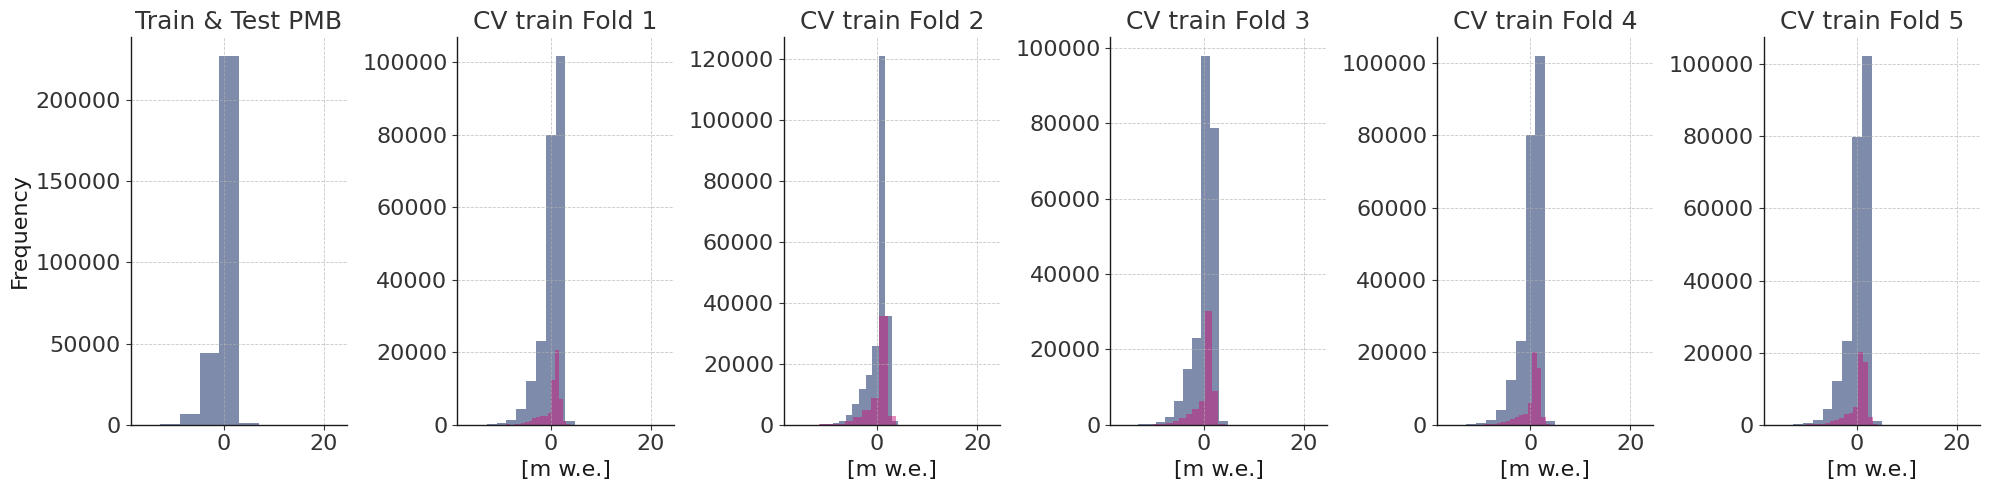

In [7]:
cv_splits, test_set, train_set = getCVSplits(dataloader_gl,
                                             test_split_on='GLACIER',
                                             test_splits=test_glaciers,
                                             random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], cv_splits)

## XGBoost:

In [8]:
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

params = {**param_init, **custom_params}
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures

print('Shape of training dataset:', train_set['df_X'][all_columns].shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

Shape of training dataset: (280720, 27)
Shape of testing dataset: (0, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']


In [9]:
custom_model

CustomXGBoostRegressor(base_score=None, booster=None, callbacks=None,
                       cfg=<massbalancemachine.config.SwitzerlandConfig object at 0x7f055650e6d0>,
                       colsample_bylevel=None, colsample_bynode=None,
                       colsample_bytree=None, device='cuda:0',
                       early_stopping_rounds=None, enable_categorical=False,
                       eval_metric=None, feature_types=None, gamma=None,
                       grow_policy=None, importance_type=None,
                       interaction_constraints=None, learning_rate=0.01,
                       max_bin=None, max_cat_threshold=None,
                       max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
                       max_leaves=None, min_child_weight=None, missing=nan,
                       monotone_constraints=None, multi_strategy=None,
                       n_estimators=800, n_jobs=25, num_parallel_tree=None, ...)

In [10]:
def cross_val_predict(custom_model, train_set, cv_splits, all_columns):
    """
    Fits the given model on training splits and evaluates on validation splits.

    Parameters:
    - custom_model: The machine learning model to fit and evaluate.
    - train_set: Dictionary containing 'y' (target) and 'df_X' (features).
    - cv_splits: List of (train_idx, val_idx) tuples for cross-validation.
    - all_columns: List of feature column names to use.

    Returns:
    - Dictionary containing mean and standard deviation of validation and training scores.
    """
    val_score, train_score = [], []

    for i, (train_idx, val_idx) in enumerate(cv_splits):
        if i > 3: # Only run on first 3 splits for speed
            break
        target_train = train_set['y'][train_idx]
        target_val = train_set['y'][val_idx]
        input_train = train_set['df_X'].iloc[train_idx][all_columns]
        input_val = train_set['df_X'].iloc[val_idx][all_columns]

        # Fit on train folds:
        custom_model.fit(input_train, target_train)

        # Ensure model is set to CPU
        custom_model = custom_model.set_params(device='cpu')

        # Calculate scores on validation and training folds:
        val_score.append(np.abs(custom_model.score(input_val, target_val)))
        train_score.append(
            np.abs(custom_model.score(input_train, target_train)))

    return {
        "mean_val_score": np.mean(val_score),
        "std_val_score": np.std(val_score),
        "mean_train_score": np.mean(train_score),
        "std_train_score": np.std(train_score),
    }

### One round only:

In [ ]:
def feature_importance_analysis(custom_model,
                                train_set,
                                cv_splits,
                                feature_columns,
                                grouped_features=None):
    """
    Evaluates the importance of each feature by removing it one at a time and calculating the impact on model performance.

    Parameters:
    - custom_model: The machine learning model to fit and evaluate.
    - train_set: Dictionary containing 'y' (target) and 'df_X' (features).
    - cv_splits: List of (train_idx, val_idx) tuples for cross-validation.
    - feature_columns: List of feature column names.
    - grouped_features: List of feature names that must always be included/excluded together.
    - parallel: Boolean, whether to run evaluations in parallel.

    Returns:
    - DataFrame with scores for each feature removed.
    """
    results = []
    features_to_remove = [
        f for f in feature_columns
        if not grouped_features or f not in grouped_features
    ]

    def evaluate_without_feature(feature):
        """Helper function to evaluate the model without a specific feature or feature group."""
        reduced_features = [f for f in feature_columns if f != feature]

        # Ensure grouped features are removed together
        if grouped_features and feature in grouped_features:
            reduced_features = [
                f for f in feature_columns if f not in grouped_features
            ]

        reduced_columns = reduced_features + cfg.fieldsNotFeatures

        # Clone the model to avoid contamination
        model_copy = copy.deepcopy(custom_model)
        model_copy = model_copy.set_params(
            device="cuda:0")  # Ensure it remains on GPU

        # Evaluate model performance with reduced feature set
        scores = cross_val_predict(model_copy, train_set, cv_splits,
                                   reduced_columns)
        scores[
            "removed_feature"] = feature if feature not in grouped_features else "Group: " + ", ".join(
                grouped_features)

        # Explicitly delete model copy to free memory
        del model_copy
        gc.collect()  # Trigger garbage collection

        return scores

    print("\nStarting feature importance analysis...\n")

    # Run evaluations in parallel or sequentially
    features_to_evaluate = features_to_remove + ([grouped_features[0]]
                                                 if grouped_features else [])

    for feature in tqdm(features_to_evaluate, desc="Evaluating Features"):
        results.append(evaluate_without_feature(feature))

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Identify the feature/group whose removal led to the highest validation score (least useful)
    least_important_feature = df_results.loc[
        df_results["mean_val_score"].idxmax(), "removed_feature"]
    print(
        f"\nLeast useful feature (highest validation score when removed): {least_important_feature}"
    )

    return df_results

In [ ]:
# # Define grouped features that should always be removed together
# grouped_features = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]

# # Run feature importance analysis
# df_feature_importance = feature_importance_analysis(custom_model, train_set,
#                                                     cv_splits, feature_columns,
#                                                     grouped_features)

# # Save results:
# df_feature_importance.to_csv('results/feature_importance.csv', index=False)

### Iterative removal:

In [15]:
def iterative_feature_elimination(custom_model,
                                  train_set,
                                  cv_splits,
                                  feature_columns,
                                  grouped_features=None,
                                  min_features=5):
    """
    Iteratively removes the least important feature (or group of features) until only `min_features` remain.

    Parameters:
    - custom_model: The machine learning model to fit and evaluate.
    - train_set: Dictionary containing 'y' (target) and 'df_X' (features).
    - cv_splits: List of (train_idx, val_idx) tuples for cross-validation.
    - feature_columns: List of feature column names.
    - grouped_features: List of feature names that must always be included/excluded together.
    - parallel: Boolean, whether to run evaluations in parallel.
    - min_features: The minimum number of features to retain.

    Returns:
    - DataFrame with scores and feature elimination history.
    """

    # Create a working copy of feature columns
    remaining_features = feature_columns.copy()
    elimination_results = []

    print("\nStarting iterative feature elimination...\n")

    round_nb = 1
    while len(remaining_features) > min_features:
        results = []
        features_to_remove = [
            f for f in remaining_features
            if not grouped_features or f not in grouped_features
        ]
        print('\nRemaining features:', remaining_features)

        def evaluate_without_feature(feature):
            print('Evaluate without ', feature)
            """Evaluates the model without a specific feature or feature group."""
            reduced_features = [f for f in remaining_features if f != feature]

            # Ensure grouped features are removed together
            if grouped_features and feature in grouped_features:
                reduced_features = [
                    f for f in remaining_features if f not in grouped_features
                ]

            reduced_columns = reduced_features + cfg.fieldsNotFeatures

            # Clone and reset model to ensure fresh training
            model_copy = copy.deepcopy(custom_model)
            model_copy = model_copy.set_params(
                device="cuda:0")  # Ensure it stays on GPU

            # Evaluate model performance with reduced feature set
            scores = cross_val_predict(model_copy, train_set, cv_splits,
                                    reduced_columns)
            scores[
                "removed_feature"] = feature if feature not in grouped_features else "Group: " + ", ".join(
                    grouped_features)

            # Explicitly delete model copy to free memory
            del model_copy
            gc.collect()  # Trigger garbage collection

            return scores

        features_to_evaluate = features_to_remove + ([grouped_features[0]] if
                                                     grouped_features else [])
        for feature in tqdm(
                    features_to_evaluate,
                    desc=
                    f"Evaluating Features (Remaining: {len(remaining_features)})"
            ):
                results.append(evaluate_without_feature(feature))

        # Convert results to DataFrame
        df_results = pd.DataFrame(results)
        df_results['remaining_feature'] = remaining_features
        df_results['Round'] = round_nb

        # Identify the least important feature (highest validation score when removed)
        least_important_feature = df_results.loc[
            df_results["mean_val_score"].idxmax(), "removed_feature"]
        print(f"\nRemoving least important feature: {least_important_feature}")

        # Store elimination history
        elimination_results.append(df_results)

        # Remove feature(s) from the remaining feature list
        if least_important_feature.startswith("Group: "):
            removed_features = least_important_feature.replace("Group: ",
                                                               "").split(", ")
            remaining_features = [
                f for f in remaining_features if f not in removed_features
            ]
        else:
            remaining_features.remove(least_important_feature)
            
        round_nb += 1

    # Compile full elimination history
    full_elimination_df = pd.concat(elimination_results, ignore_index=True)

    return full_elimination_df

In [ ]:
# Define grouped features that should always be removed together
grouped_features = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]

# Run iterative feature elimination
df_elimination_history = iterative_feature_elimination(custom_model, train_set,
                                                       cv_splits,
                                                       feature_columns,
                                                       grouped_features)

df_elimination_history.to_csv('results/df_elimination_history.csv', index=False)


Starting iterative feature elimination...


Remaining features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']


Evaluating Features (Remaining: 16):   0%|          | 0/14 [00:00<?, ?it/s]

Evaluate without  ELEVATION_DIFFERENCE


In [ ]:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
grouped_features = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]

df_elimination_history = pd.read_csv('results/df_elimination_history.csv')
df_elimination_history